# Semantic Segmentation

In this project we will train a UNet model to perform semantic segmentation of people contained in the pictures of the <a href="https://www.cis.upenn.edu/~jshi/ped_html/">PennFudanPed dataset</a>. This dataset contains pictures of people walking, and the relative masks:

<center><img src="notebook_ims/segmentation.png" width="70%"></center>

Each person in the picture corresponds to a certain value in the mask. However, in this exercise we are interested in _semantic_ segmentation and not _instance_ segmentation, so we will consider all people as part of the same class. This means that we have two classes: people, and background (i.e., it is a binary segmentation):

<center><img src="notebook_ims/semantic_segmentation.png" width="70%"></center>

Let's start by installing the requirements for this exercise:

In [1]:
!pip install -r requirements.txt

> Wait for the previous cell to complete, then restart the kernel before running the next cell. This ensures that the dependencies we have just installed will work. Of course, the second time DO NOT rerun the previous cell, but start from the next one

## Setting Up

Let's import a bunch of modules that we will need in the notebook. We also initialize the random number generators belonging to a few different packages to ensure repeatibility:

In [67]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from helpers import PennFudanDataset
from helpers import get_data_loaders
import matplotlib.pyplot as plt
from torch import nn
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import random
import metrics
import numpy as np
import cv2

# Seed random generator for repeatibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


### Transforms for Semantic Segmentation

Data augmentations are an important part of creating a performant neural network for image processing. In the case of segmentation, it is obviously very important that all the geometric transformations that we apply as part of data augmentation are applied to both the image and the mask, otherwise the mask would not represent the semantic information in the image anymore.

For this, we use the nice `albumentations` library that provides transformations that take care of that automatically. If you are curious to know how this is accomplished, consider this code in the `helpers.py` file, within the `PennFudanDataset` class:

```python
if self.transforms is not None:
    aug = self.transforms(image=img, mask=mask)
    img, mask = aug['image'], aug['mask']
```
As you can see, the transformations (contained in `self.transforms`) are applied to both the image and the mask.

We define two sets of transformations, one for the training set (containing augmentations) and one for the validation set (without augmentations).

> Since the dataset is small (there are only a total of 170 images) we cannot afford to divide it 3 ways (train, validation, and test). We therefore only divide it in two (train and validation). In a real-world use case, you would do k-fold cross-validation and repeat this split multiple times, recording the results of your training for each one of those. Here, for simplicity and to save time, we will not do that and will just train on the training dataset and evaluate on the validation dataset.

In [68]:
# The input of a UNET with 5 downsampling operations
# needs to be divisible by 2**5 = 32 in both width
# and height. For simplicity we use square images
SIZE = 448

train_transforms = A.Compose(
    [
        # We first pad to make sure we have a dimension of
        # at least SIZE x SIZE. If padding is needed (because an image is
        # smaller than SIZE x SIZE), then a constant padding with green color
        # is added
        A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0, 255, 0)),
        # Augmentations
        # We use a random crop instead of a center crop so each time the network
        # will see a different image
        A.RandomCrop(SIZE, SIZE),
        # Other augmentations. See the manual of the Albumentations package for
        # an explanation of what each one of these do
        A.HorizontalFlip(),
        A.OneOf(
            [
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1),
                A.PiecewiseAffine(p=0.3),
            ],
            p=0.3,
        ),
        A.OneOf(
            [
                A.HueSaturationValue(10, 15, 10),
                A.CLAHE(clip_limit=2),
                A.RandomBrightnessContrast(),
            ],
            p=0.3,
        ),
        # Normalization
        A.Normalize(PennFudanDataset.mean, PennFudanDataset.std),
        ToTensorV2(),
    ]
)

valid_transforms = A.Compose(
    [
        A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0, 255, 0)),
        A.CenterCrop(SIZE, SIZE),
        A.Normalize(PennFudanDataset.mean, PennFudanDataset.std),
        ToTensorV2(),
    ]
)

We can  now get the data loaders. Since this is mostly boilerplate code, we have saved you the trouble and provide a function for this in `helpers.py`. Please refer to the code if you are curious to see how this is accomplished.

In [3]:
dl = get_data_loaders(
    "PennFudanPed", train_transforms, valid_transforms, num_workers=-1, batch_size=4
)

## Define the Model
We are going to use a UNet architecture:

<center><img src="notebook_ims/unet.png" width="50%"></center>

We use [efficientnet-b2](https://paperswithcode.com/method/efficientnet) as backbone, pre-trained on ImageNet:

In [4]:
model = smp.Unet(
        encoder_name='efficientnet-b2',
        encoder_weights='imagenet',
        in_channels=3,
        # Binary classification
        classes=1
    )

## Training
As usual, we need to define a loss and an optimizer that will minimize that loss. We use the Dice loss, which directly optimizes the IoU metric that we are interested in. We also use a different learning rate for the backbone/encoder (the pre-trained EfficientNet) and the decoder (which is new and needs to be trained from scratch). We want the weights in the decoder to move much more quickly than the weights in the encoder, since the latter has been trained on ImageNet and is therefore already a very good feature extractor.

In [5]:
loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-1},
    {'params': model.encoder.parameters(), 'lr': 1e-3},
])

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def train_one_epoch(epoch, model, data_loaders, optimizer, loss_function):
    # Set the model to train mode
    model.train()
    
    # Move to the GPU if available
    model.to(DEVICE)
    
    # Training loop
    train_loss = 0
    
    for i, (imgs, masks) in tqdm(
        enumerate(data_loaders["train"]), total=len(data_loaders["train"]), ncols=60
    ):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Move images and masks to the GPU (if available)
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Execute a forward pass
        outputs = model(imgs)
        # Compute loss
        loss = loss_function(outputs, masks)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item()
    
    # Compute average loss for this epoch
    train_loss /= len(data_loaders["train"])

    # Validate
    # Put the model in evaluation state
    model.eval()
    
    # Loop and accumulate the validation loss, as well as the 
    # True Positives, False Positives, False Negatives, True Negatives.
    # We will use these to compute the Intersection over Union metric
    # at the end of the validation phase
    valid_loss = 0

    tp, fp, fn, tn = [0] * 4

    with torch.no_grad():
        for i, (imgs, masks) in tqdm(
            enumerate(data_loaders["valid"]), total=len(data_loaders["valid"]), ncols=60
        ):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            valid_loss += loss.item()

            # Compute statistics for true positives, false positives, false negative and
            # true negative "pixels"
            this_tp, this_fp, this_fn, this_tn = metrics.get_stats(
                outputs.squeeze(), masks.squeeze(), mode="binary", threshold=0.5
            )

            tp += this_tp
            fp += this_fp
            fn += this_fn
            tn += this_tn

    # compute Intersection Over Union
    iou_score = metrics.iou_score(sum(tp), sum(fp), sum(fn), sum(tn), reduction="micro")

    valid_loss /= len(data_loaders["valid"])

    return train_loss, valid_loss, iou_score

In [7]:
# Reduce the learning rate by a factor of 10 every 30 epochs
scheduler = StepLR(optimizer, step_size=30, gamma=0.1, verbose=False)

# Train for a few epochs, printing the progress along the way
for epoch in range(50):
    
    train_loss, valid_loss, iou = train_one_epoch(epoch, model, dl, optimizer, loss)
    print(f"EPOCH: {epoch + 1} - train loss: {train_loss} -  valid_loss: {valid_loss} - IoU: {iou:.3f}")
    
    scheduler.step()

100%|███████████████████████| 34/34 [00:06<00:00,  5.09it/s]


EPOCH: 1 - train loss: 0.47839055517140555 -  valid_loss: 0.18335712481947505 - IoU: 0.750


100%|███████████████████████| 34/34 [00:06<00:00,  5.08it/s]


EPOCH: 2 - train loss: 0.19355406305369208 -  valid_loss: 0.19486260414123535 - IoU: 0.684


100%|███████████████████████| 34/34 [00:06<00:00,  5.01it/s]


EPOCH: 3 - train loss: 0.14948624898405635 -  valid_loss: 0.1708006928948795 - IoU: 0.717


100%|███████████████████████| 34/34 [00:06<00:00,  5.01it/s]


EPOCH: 4 - train loss: 0.1406418611021603 -  valid_loss: 0.1202622652053833 - IoU: 0.796


100%|███████████████████████| 34/34 [00:06<00:00,  4.88it/s]


EPOCH: 5 - train loss: 0.11793307346456192 -  valid_loss: 0.1257224714054781 - IoU: 0.793


100%|███████████████████████| 34/34 [00:06<00:00,  5.02it/s]


EPOCH: 6 - train loss: 0.11194556074983933 -  valid_loss: 0.1001804786569932 - IoU: 0.822


100%|███████████████████████| 34/34 [00:06<00:00,  5.03it/s]


EPOCH: 7 - train loss: 0.11601625996477463 -  valid_loss: 0.10018504717770745 - IoU: 0.834


100%|███████████████████████| 34/34 [00:07<00:00,  4.85it/s]


EPOCH: 8 - train loss: 0.09553302561535555 -  valid_loss: 0.08930771140491262 - IoU: 0.844


100%|███████████████████████| 34/34 [00:06<00:00,  4.88it/s]


EPOCH: 9 - train loss: 0.08530118360238917 -  valid_loss: 0.08716028928756714 - IoU: 0.847


100%|███████████████████████| 34/34 [00:07<00:00,  4.42it/s]


EPOCH: 10 - train loss: 0.08523937709191266 -  valid_loss: 0.08589506850523107 - IoU: 0.847


100%|███████████████████████| 34/34 [00:06<00:00,  4.90it/s]


EPOCH: 11 - train loss: 0.08283417365130256 -  valid_loss: 0.0805581089328317 - IoU: 0.859


100%|███████████████████████| 34/34 [00:06<00:00,  5.10it/s]


EPOCH: 12 - train loss: 0.0779685360543868 -  valid_loss: 0.09331540675724254 - IoU: 0.840


100%|███████████████████████| 34/34 [00:06<00:00,  4.95it/s]


EPOCH: 13 - train loss: 0.0852788160828983 -  valid_loss: 0.11312137105885674 - IoU: 0.793


100%|███████████████████████| 34/34 [00:07<00:00,  4.43it/s]


EPOCH: 14 - train loss: 0.07702385678010829 -  valid_loss: 0.09177147114978117 - IoU: 0.841


100%|███████████████████████| 34/34 [00:06<00:00,  4.92it/s]


EPOCH: 15 - train loss: 0.07031023502349854 -  valid_loss: 0.0794815736658433 - IoU: 0.855


100%|███████████████████████| 34/34 [00:06<00:00,  4.94it/s]


EPOCH: 16 - train loss: 0.06901180568863363 -  valid_loss: 0.09623809772379258 - IoU: 0.823


100%|███████████████████████| 34/34 [00:06<00:00,  5.00it/s]


EPOCH: 17 - train loss: 0.06975924092180588 -  valid_loss: 0.08607899266130783 - IoU: 0.841


100%|███████████████████████| 34/34 [00:06<00:00,  5.00it/s]


EPOCH: 18 - train loss: 0.06496913643444285 -  valid_loss: 0.08593445665696088 - IoU: 0.846


100%|███████████████████████| 34/34 [00:06<00:00,  4.95it/s]


EPOCH: 19 - train loss: 0.08151169384227079 -  valid_loss: 0.1002224070184371 - IoU: 0.820


100%|███████████████████████| 34/34 [00:06<00:00,  4.91it/s]


EPOCH: 20 - train loss: 0.06619043385281283 -  valid_loss: 0.0790398103349349 - IoU: 0.861


100%|███████████████████████| 34/34 [00:06<00:00,  4.94it/s]


EPOCH: 21 - train loss: 0.06108901255271014 -  valid_loss: 0.07639046101009145 - IoU: 0.866


100%|███████████████████████| 34/34 [00:07<00:00,  4.85it/s]


EPOCH: 22 - train loss: 0.05623951028375065 -  valid_loss: 0.07765931066344767 - IoU: 0.866


100%|███████████████████████| 34/34 [00:07<00:00,  4.76it/s]


EPOCH: 23 - train loss: 0.07158876517239739 -  valid_loss: 0.10756038392291349 - IoU: 0.815


100%|███████████████████████| 34/34 [00:07<00:00,  4.84it/s]


EPOCH: 24 - train loss: 0.07308769401381998 -  valid_loss: 0.07983727665508494 - IoU: 0.860


100%|███████████████████████| 34/34 [00:06<00:00,  4.90it/s]


EPOCH: 25 - train loss: 0.06867076018277336 -  valid_loss: 0.08587951344602249 - IoU: 0.845


100%|███████████████████████| 34/34 [00:06<00:00,  4.87it/s]


EPOCH: 26 - train loss: 0.05987967287792879 -  valid_loss: 0.07819472866899826 - IoU: 0.860


100%|███████████████████████| 34/34 [00:07<00:00,  4.85it/s]


EPOCH: 27 - train loss: 0.054576833458507765 -  valid_loss: 0.08301306647412918 - IoU: 0.849


100%|███████████████████████| 34/34 [00:06<00:00,  4.98it/s]


EPOCH: 28 - train loss: 0.04986112258013557 -  valid_loss: 0.0761718890246223 - IoU: 0.864


100%|███████████████████████| 34/34 [00:06<00:00,  4.90it/s]


EPOCH: 29 - train loss: 0.0546049458139083 -  valid_loss: 0.07453622537500718 - IoU: 0.868


100%|███████████████████████| 34/34 [00:06<00:00,  4.96it/s]


EPOCH: 30 - train loss: 0.055918406037723314 -  valid_loss: 0.0763447056798374 - IoU: 0.866


100%|███████████████████████| 34/34 [00:06<00:00,  4.97it/s]


EPOCH: 31 - train loss: 0.05405588009778191 -  valid_loss: 0.07426247351309832 - IoU: 0.868


100%|███████████████████████| 34/34 [00:06<00:00,  4.95it/s]


EPOCH: 32 - train loss: 0.04858200865633348 -  valid_loss: 0.07139973079457003 - IoU: 0.874


100%|███████████████████████| 34/34 [00:06<00:00,  4.93it/s]


EPOCH: 33 - train loss: 0.04508579653852126 -  valid_loss: 0.07058964932666105 - IoU: 0.875


100%|███████████████████████| 34/34 [00:06<00:00,  4.97it/s]


EPOCH: 34 - train loss: 0.04511985358069925 -  valid_loss: 0.06926866489298203 - IoU: 0.878


100%|███████████████████████| 34/34 [00:06<00:00,  4.98it/s]


EPOCH: 35 - train loss: 0.0443747481879066 -  valid_loss: 0.0693973390495076 - IoU: 0.876


100%|███████████████████████| 34/34 [00:06<00:00,  4.99it/s]


EPOCH: 36 - train loss: 0.04368450010524077 -  valid_loss: 0.06808161910842447 - IoU: 0.879


100%|███████████████████████| 34/34 [00:06<00:00,  4.94it/s]


EPOCH: 37 - train loss: 0.04781097874921911 -  valid_loss: 0.0687351033968084 - IoU: 0.878


100%|███████████████████████| 34/34 [00:06<00:00,  5.01it/s]


EPOCH: 38 - train loss: 0.04399622889126048 -  valid_loss: 0.06766365906771492 - IoU: 0.880


100%|███████████████████████| 34/34 [00:06<00:00,  4.86it/s]


EPOCH: 39 - train loss: 0.04191197893198799 -  valid_loss: 0.06780370894600363 - IoU: 0.880


100%|███████████████████████| 34/34 [00:06<00:00,  4.90it/s]


EPOCH: 40 - train loss: 0.041232510524637556 -  valid_loss: 0.06738455505932078 - IoU: 0.881


100%|███████████████████████| 34/34 [00:06<00:00,  4.93it/s]


EPOCH: 41 - train loss: 0.04113934145254247 -  valid_loss: 0.067345051204457 - IoU: 0.881


100%|███████████████████████| 34/34 [00:06<00:00,  4.96it/s]


EPOCH: 42 - train loss: 0.04139842706568101 -  valid_loss: 0.06697777614873998 - IoU: 0.882


100%|███████████████████████| 34/34 [00:06<00:00,  5.01it/s]


EPOCH: 43 - train loss: 0.042590912650613225 -  valid_loss: 0.06657848288031186 - IoU: 0.883


100%|███████████████████████| 34/34 [00:06<00:00,  4.92it/s]


EPOCH: 44 - train loss: 0.043142513317220355 -  valid_loss: 0.06667501786175896 - IoU: 0.883


100%|███████████████████████| 34/34 [00:06<00:00,  5.01it/s]


EPOCH: 45 - train loss: 0.04107926873599782 -  valid_loss: 0.06651336305281695 - IoU: 0.883


100%|███████████████████████| 34/34 [00:06<00:00,  4.95it/s]


EPOCH: 46 - train loss: 0.04287495683221256 -  valid_loss: 0.06632096977794871 - IoU: 0.883


100%|███████████████████████| 34/34 [00:06<00:00,  4.90it/s]


EPOCH: 47 - train loss: 0.03964038456187529 -  valid_loss: 0.06765610680860631 - IoU: 0.880


100%|███████████████████████| 34/34 [00:06<00:00,  4.99it/s]


EPOCH: 48 - train loss: 0.03993744709912468 -  valid_loss: 0.06680149716489456 - IoU: 0.881


100%|███████████████████████| 34/34 [00:06<00:00,  4.93it/s]


EPOCH: 49 - train loss: 0.04123071712606093 -  valid_loss: 0.06782080320750966 - IoU: 0.880


100%|███████████████████████| 34/34 [00:06<00:00,  4.94it/s]

EPOCH: 50 - train loss: 0.04029786411453696 -  valid_loss: 0.06673834253759946 - IoU: 0.881


## Results

Our model has an average IoU of almost 88%, which is very good considering how small this dataset is. Let's plot some results to have an idea of how the model is performing in reality:

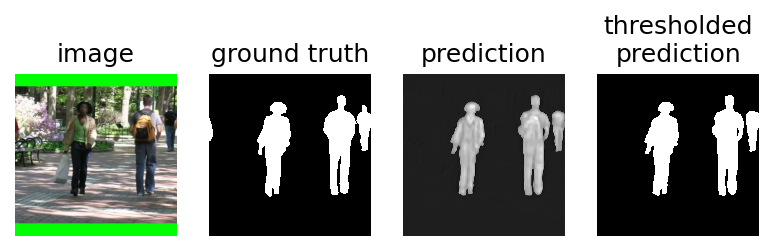

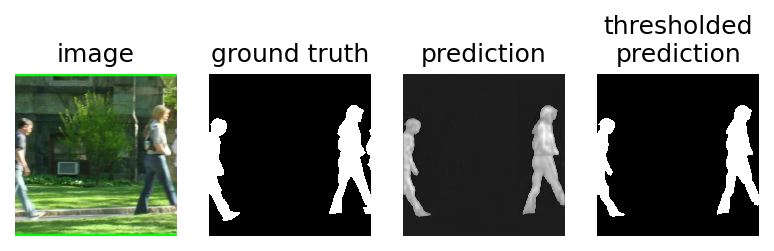

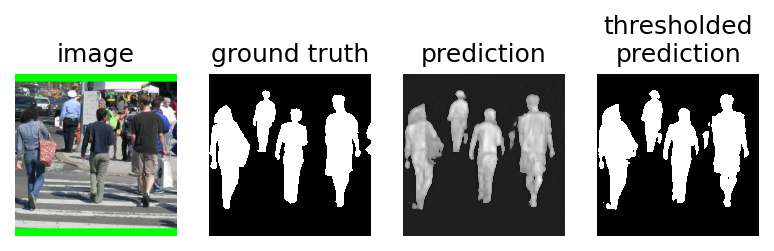

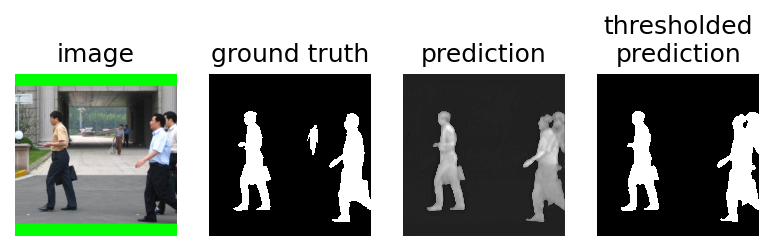

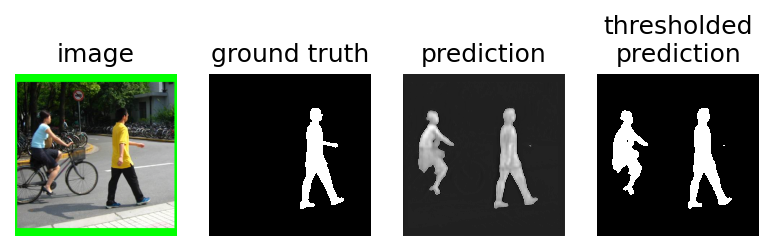

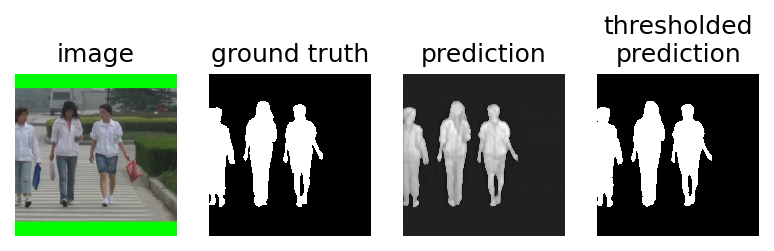

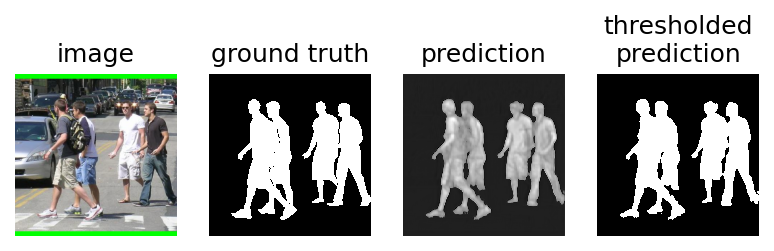

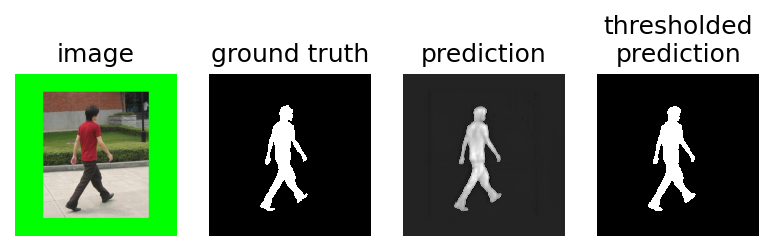

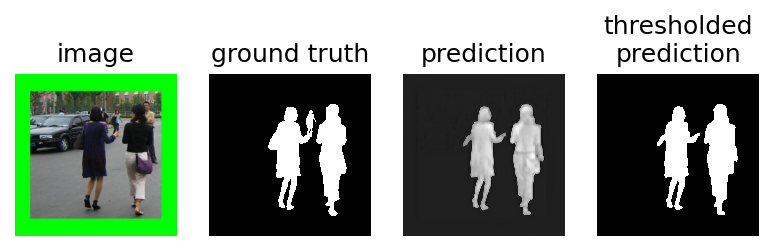

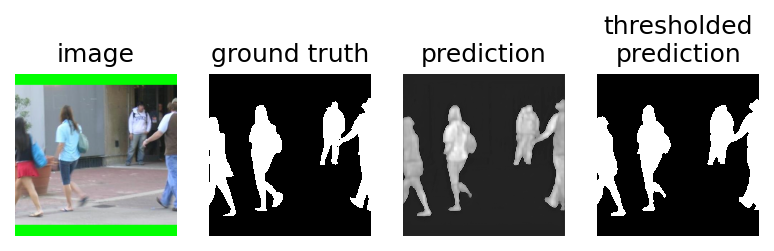

In [8]:
import torchvision.transforms as T
import numpy as np

def plot_some_results(n=10):
    
    valid_it = iter(dl['valid'])
    
    for _ in range(n):

        image, gt_mask = next(valid_it)
        with torch.no_grad():
            pred = model(image.cuda())[0]

        # Invert the T.Normalize transform
        unnormalize = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean = [ 0., 0., 0. ], std = 1 / PennFudanDataset.std),
                T.Normalize(mean = -PennFudanDataset.mean, std = [ 1., 1., 1. ])
            ]
        )

        image = (unnormalize(image.squeeze().numpy().T) * 255).numpy().astype(np.uint8)

        fig, ax = plt.subplots(1, 4, dpi=150)

        _ = ax[0].imshow(image.T)
        _ = ax[1].imshow(gt_mask.squeeze() * 255, cmap='gray', interpolation='none')
        _ = ax[2].imshow(pred.cpu().squeeze(), cmap='gray', interpolation='none')
        _ = ax[3].imshow((pred.cpu().squeeze() > 0) * 255, cmap='gray', interpolation='none')

        _ = [sub.axis("off") for sub in ax.flatten()]
        ax[0].set_title("image")
        ax[1].set_title("ground truth")
        ax[2].set_title("prediction")
        ax[3].set_title("thresholded\nprediction")

plot_some_results()

In general, our model seems to perform very well given how little data it has seen. It's not perfect though. We can also see that sometimes the ground truth itself is imprecise and sometimes our model is actually better than the ground truth.

We can see here a few more interesting things. Looking at the prediction column (which is the output of the model as is), we can see that the people have structures that resemble their clothing. 

> Can you guess why that is the case?

Because UNet takes the tensor coming from the upsampling operations and sums it with the feature maps corresponding to that level in the decoder. In particular, the input image as-is gets summed to the output of the last layer in the decoder. Therfore some sharp features in the input image get projected into the prediction of the model.